# Linear Regression Project: Predicting Nutritional Values from Food Product Data

This notebook demonstrates a comprehensive linear regression workflow using the Open Food Facts `products.tsv` dataset. The goal is to predict a nutritional value (e.g., energy per 100g) from other product features. The project covers data cleaning, feature selection, feature engineering, model training, evaluation, and interpretation.

## Data Source and Objective

- **Data Source:** [Kaggle](https://www.kaggle.com/datasets/openfoodfacts/world-food-facts), file: `data_source/products.tsv`
- **Objective:** Predict the energy content (kcal per 100g) of food products using other nutritional and product features via linear regression.
- **Workflow:** Data loading, cleaning, feature selection, feature engineering, model training, evaluation, and interpretation.

## 1. Data Loading and Initial Exploration

We will load a sample of the data for performance, inspect its structure, and identify relevant columns for regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Load a sample of the data (first 5000 rows for performance)
df = pd.read_csv('../data_source/products.tsv', sep='\t', low_memory=False, nrows=5000)
display(df.shape)
display(df.head())
display(df.info())

(5000, 163)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(109), int64(3), object(51)
memory usage: 6.2+ MB


None

## 2. Data Cleaning, Feature Selection, and Engineering

We will select relevant features, clean the data (handle missing values, outliers, and types), and engineer new features for regression.

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Select relevant columns
columns = [
    'product_name', 'brands', 'categories', 'countries_en',
    'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g',
    'fiber_100g', 'proteins_100g', 'salt_100g'
]
df_reg = df[columns].copy()

def to_float(x):
    try:
        return float(x)
    except:
        return np.nan
for col in columns[4:]:
    df_reg[col] = df_reg[col].apply(to_float)
df_reg = df_reg.dropna(subset=['product_name'])
df_reg = df_reg.dropna(subset=columns[4:], how='all')

# Remove outliers (1st and 99th percentiles)
for col in columns[4:]:
    q_low = df_reg[col].quantile(0.01)
    q_high = df_reg[col].quantile(0.99)
    df_reg = df_reg[(df_reg[col].isna()) | ((df_reg[col] >= q_low) & (df_reg[col] <= q_high))]

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df_reg[columns[4:]] = imputer.fit_transform(df_reg[columns[4:]])

# Feature engineering: category, brand, country (first value), product length, ratios
# Main category
df_reg['main_category'] = df_reg['categories'].str.split(',').str[0].str.strip().fillna('Unknown')
le_cat = LabelEncoder()
df_reg['main_category_encoded'] = le_cat.fit_transform(df_reg['main_category'])
# Brand
df_reg['main_brand'] = df_reg['brands'].str.split(',').str[0].str.strip().fillna('Unknown')
le_brand = LabelEncoder()
df_reg['main_brand_encoded'] = le_brand.fit_transform(df_reg['main_brand'])
# Country
df_reg['main_country'] = df_reg['countries_en'].str.split(',').str[0].str.strip().fillna('Unknown')
le_country = LabelEncoder()
df_reg['main_country_encoded'] = le_country.fit_transform(df_reg['main_country'])
# Product name length

df_reg['product_name_length'] = df_reg['product_name'].astype(str).apply(len)
# Ratios
with np.errstate(divide='ignore', invalid='ignore'):
    df_reg['sugar_to_carb'] = np.where(df_reg['carbohydrates_100g'] > 0, df_reg['sugars_100g'] / df_reg['carbohydrates_100g'], 0)
    df_reg['protein_to_fat'] = np.where(df_reg['fat_100g'] > 0, df_reg['proteins_100g'] / df_reg['fat_100g'], 0)
    df_reg['fiber_to_carb'] = np.where(df_reg['carbohydrates_100g'] > 0, df_reg['fiber_100g'] / df_reg['carbohydrates_100g'], 0)

# Final feature list for regression
feature_cols = [
    'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
    'main_category_encoded', 'main_brand_encoded', 'main_country_encoded',
    'product_name_length', 'sugar_to_carb', 'protein_to_fat', 'fiber_to_carb'
]

display(df_reg[feature_cols + ['energy_100g']].describe())
display(df_reg.head())

,fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,main_category_encoded,main_brand_encoded,main_country_encoded,product_name_length,sugar_to_carb,protein_to_fat,fiber_to_carb,energy_100g
count,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000,4510.000000
mean,12.962794,31.884761,15.679988,2.540102,6.318182,1.183084,57.426386,216.213969,6.873614,26.821951,0.506529,1.015183,0.116215,1136.541929
std,15.667991,26.572978,17.975177,3.158793,6.868217,2.303225,4.812175,92.144460,0.781801,13.477991,0.565636,2.944877,0.325580,797.796821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.670000,2.400000,0.000000,0.725000,0.127000,58.000000,177.000000,7.000000,17.000000,0.088460,0.000000,0.000000,344.000000
50%,5.710000,25.000000,7.140000,1.700000,4.420000,0.678180,58.000000,177.000000,7.000000,24.000000,0.500000,0.222153,0.048000,1151.000000
75%,21.430000,55.000000,25.412500,3.000000,8.890000,1.379220,58.000000,292.000000,7.000000,34.000000,0.833168,0.833313,0.133733,1720.000000
max,66.670000,92.860000,76.190000,20.000000,35.710000,25.400000,74.000000,415.000000,7.000000,143.000000,23.800000,73.000000,17.000000,2971.000000


,product_name,brands,categories,countries_en,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,...,main_category,main_category_encoded,main_brand,main_brand_encoded,main_country,main_country_encoded,product_name_length,sugar_to_carb,protein_to_fat,fiber_to_carb
1,Banana Chips Sweetened (Whole),NaN,NaN,United States,2243.0,28.57,64.29,14.29,3.6,3.57,...,Unknown,58,Unknown,387,United States,7,30,0.222274,0.124956,0.055996
2,Peanuts,Torn & Glasser,NaN,United States,1941.0,17.86,60.71,17.86,7.1,17.86,...,Unknown,58,Torn & Glasser,372,United States,7,7,0.294185,1.000000,0.116949
3,Organic Salted Nut Mix,Grizzlies,NaN,United States,2540.0,57.14,17.86,3.57,7.1,17.86,...,Unknown,58,Grizzlies,137,United States,7,22,0.199888,0.312566,0.397536
4,Organic Polenta,Bob's Red Mill,NaN,United States,1552.0,1.43,77.14,7.14,5.7,8.57,...,Unknown,58,Bob's Red Mill,42,United States,7,15,0.092559,5.993007,0.073892
5,Breadshop Honey Gone Nuts Granola,Unfi,NaN,United States,1933.0,18.27,63.46,11.54,7.7,13.46,...,Unknown,58,Unfi,384,United States,7,33,0.181847,0.736727,0.121336


## 3. Exploratory Data Analysis (EDA)

Visualize relationships between features and the target variable to inform model selection and feature importance.

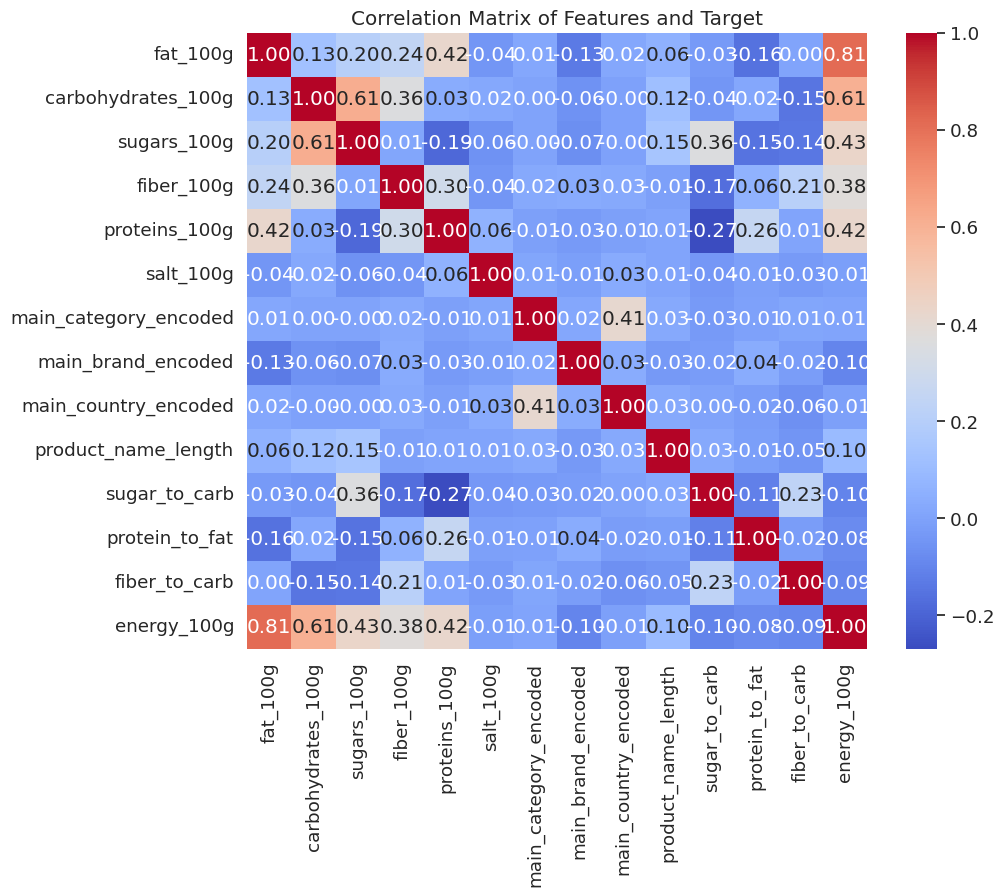

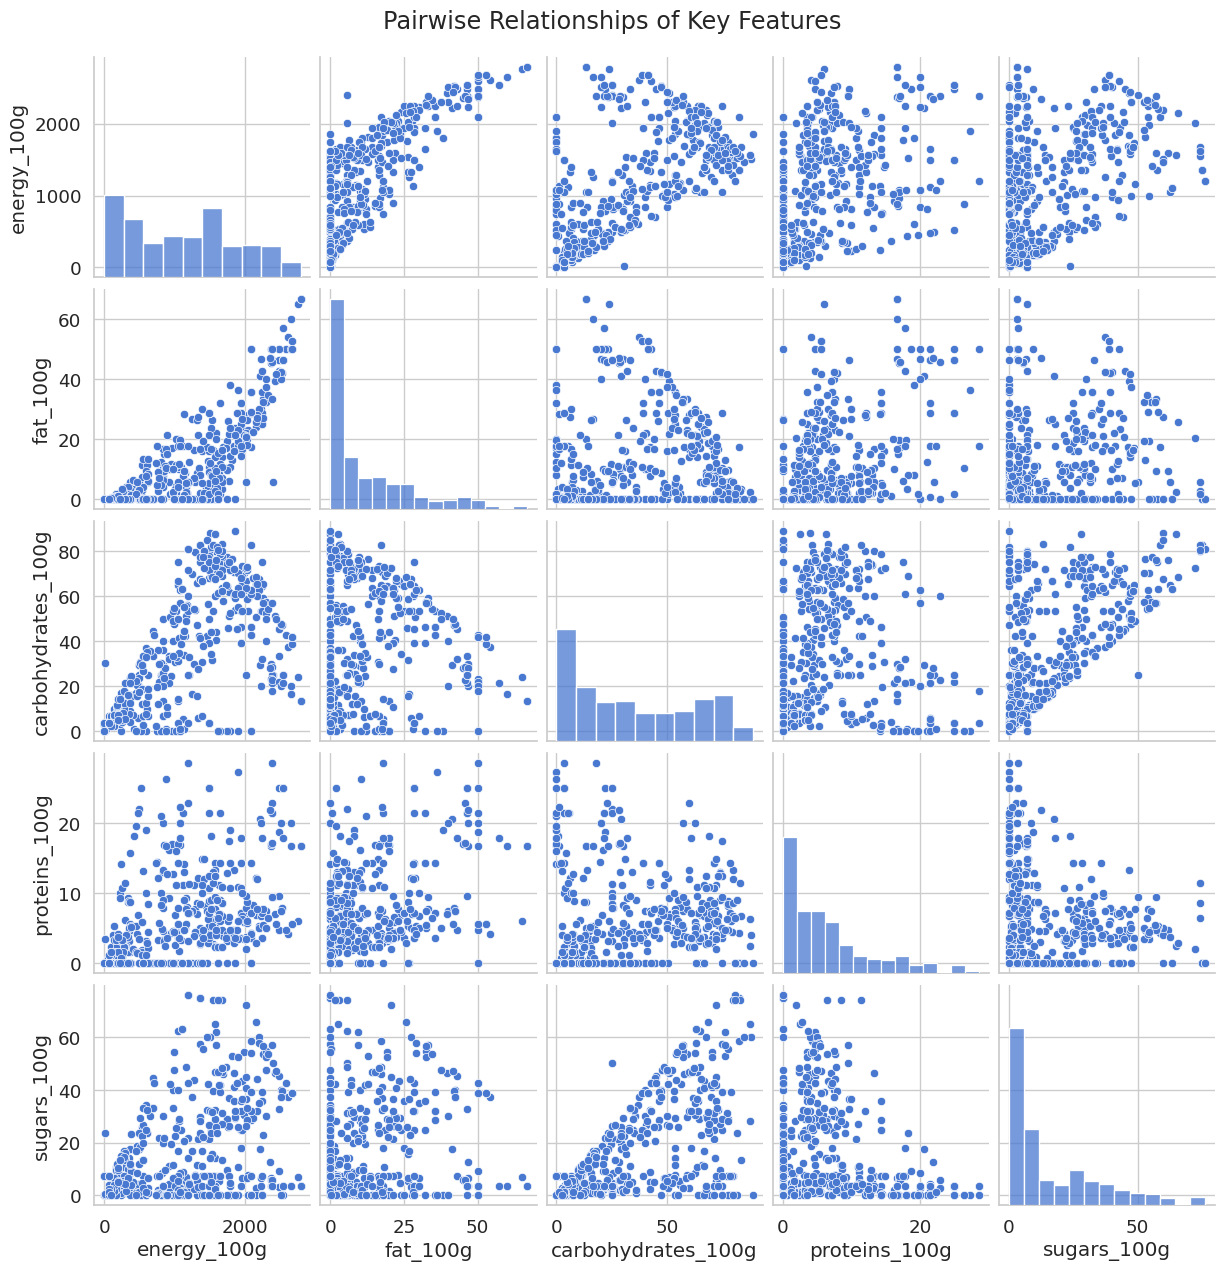

In [3]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg[feature_cols + ['energy_100g']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Features and Target')
plt.show()

# Pairplot for selected features
sns.pairplot(df_reg[['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sugars_100g']].sample(500, random_state=42))
plt.suptitle('Pairwise Relationships of Key Features', y=1.02)
plt.show()

## 4. Linear Regression Model Training and Evaluation

We will split the data, train a linear regression model, evaluate its performance, and interpret the results.

Test MSE: 65878.34
Test R^2: 0.89


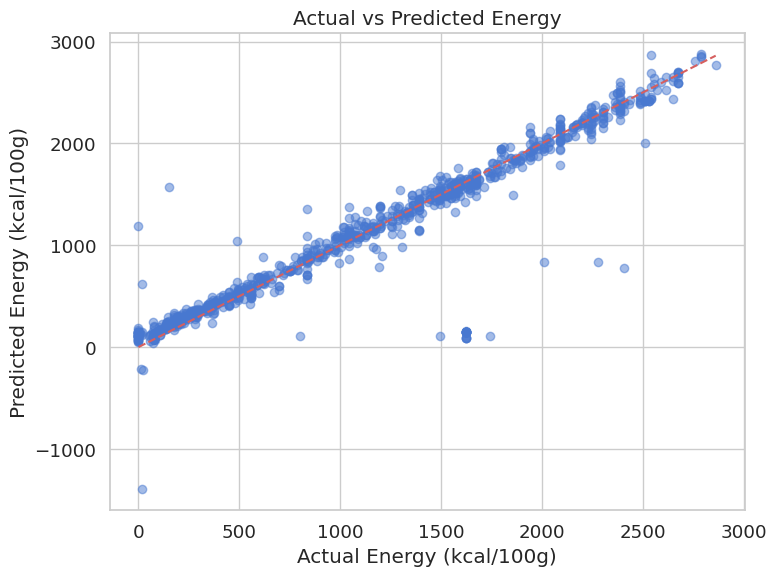

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_reg[feature_cols]
y = df_reg['energy_100g']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy (kcal/100g)')
plt.ylabel('Predicted Energy (kcal/100g)')
plt.title('Actual vs Predicted Energy')
plt.tight_layout()
plt.show()

## 5. Model Interpretation and Feature Importance

We will interpret the linear regression coefficients to understand which features are most influential in predicting energy content.

fat_100g                 566.172786
carbohydrates_100g       414.016573
proteins_100g             87.538807
fiber_to_carb            -28.816549
main_brand_encoded        21.152015
sugar_to_carb            -16.239257
main_country_encoded     -11.230203
fiber_100g                -5.232728
protein_to_fat            -4.161990
sugars_100g               -2.474866
product_name_length       -1.083630
salt_100g                  0.932568
main_category_encoded      0.217925
dtype: float64


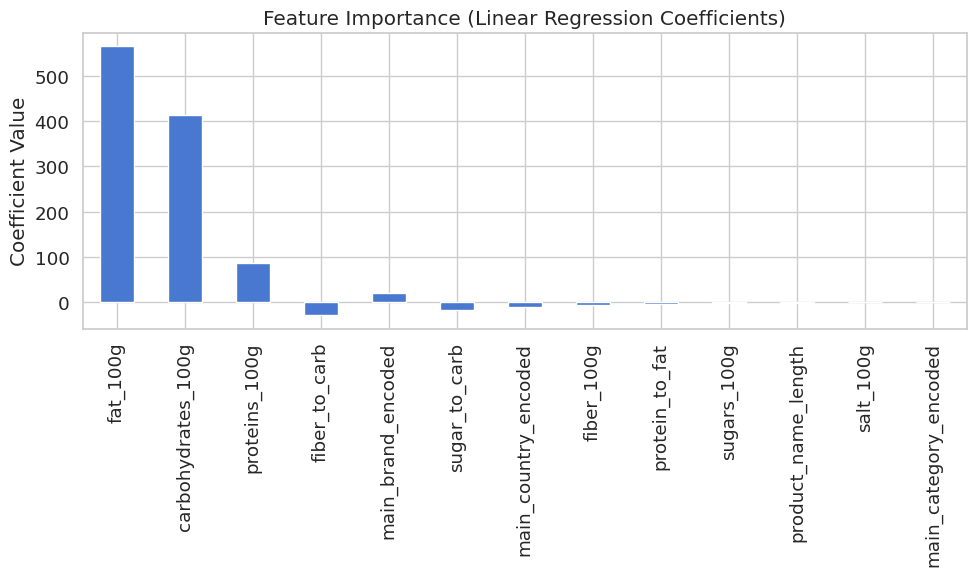

In [5]:
coef = model.coef_
feature_importance = pd.Series(coef, index=feature_cols).sort_values(key=abs, ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

## 6. Conclusion

This notebook demonstrated a full linear regression workflow using the Open Food Facts products dataset:
- Data cleaning and advanced feature engineering
- Exploratory data analysis
- Model training, evaluation, and interpretation
